Original shape: (454, 6)
PCA reduced shape: (454, 2)
KNN Results (After PCA):
Accuracy: 0.48, Precision: 0.51, Recall: 0.84, F1 Score: 0.64

Naive Bayes Results (After PCA):
Accuracy: 0.54, Precision: 0.54, Recall: 0.96, F1 Score: 0.69


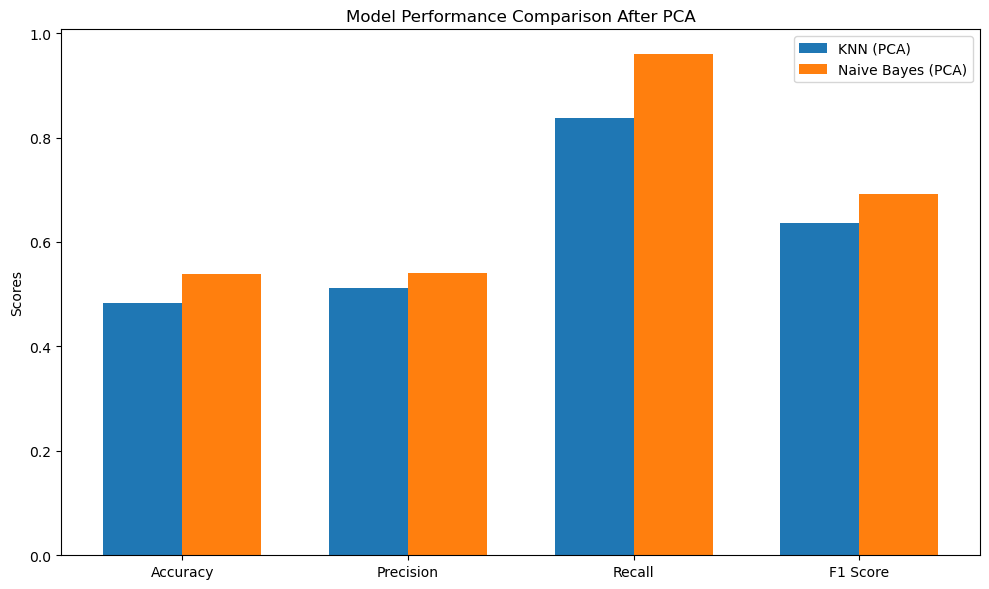

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Load the dataset
df = pd.read_csv("ABNB.csv")

# Fill missing 'Close' with mean
df['Close'] = df['Close'].fillna(df['Close'].mean())

# Create Target column
df['Target'] = (df['Close'].shift(-1) > df['Close']).astype(int)

# Feature and target selection
features = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
X = df[features].values
y = df['Target'].values

# Scale features (very important for PCA)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA to retain 95% variance
pca = PCA(n_components=0.99)
X_pca = pca.fit_transform(X_scaled)

print(f"Original shape: {X.shape}")
print(f"PCA reduced shape: {X_pca.shape}")

# Train-test split (80-20)
split = int(0.8 * len(df))
X_train, X_test = X_pca[:split], X_pca[split:]
y_train, y_test = y[:split], y[split:]

# ---------- KNN (Manual) ----------
def knn_predict(X_train, y_train, X_test_point, k=3):
    distances = [np.linalg.norm(x - X_test_point) for x in X_train]
    k_indices = np.argsort(distances)[:k]
    k_labels = [y_train[i] for i in k_indices]
    most_common = Counter(k_labels).most_common(1)[0][0]
    return most_common

y_pred_knn = [knn_predict(X_train, y_train, x, k=5) for x in X_test]

# ---------- Naive Bayes (Manual, Gaussian) ----------
def gaussian_prob(x, mean, std):
    eps = 1e-6
    return (1.0 / (np.sqrt(2 * np.pi) * (std + eps))) * np.exp(- ((x - mean) ** 2) / (2 * (std + eps) ** 2))

def naive_bayes_predict(X_train, y_train, X_test):
    labels = np.unique(y_train)
    means, stds, priors = {}, {}, {}

    for label in labels:
        X_l = X_train[y_train == label]
        means[label] = X_l.mean(axis=0)
        stds[label] = X_l.std(axis=0)
        priors[label] = len(X_l) / len(X_train)

    predictions = []
    for x in X_test:
        probs = {}
        for label in labels:
            prob = np.log(priors[label])
            for i in range(len(x)):
                prob += np.log(gaussian_prob(x[i], means[label][i], stds[label][i]))
            probs[label] = prob
        predicted = max(probs, key=probs.get)
        predictions.append(predicted)
    return predictions

y_pred_nb = naive_bayes_predict(X_train, y_train, X_test)

# ---------- Evaluation ----------
def evaluate(y_true, y_pred):
    TP = sum((y_true[i] == 1 and y_pred[i] == 1) for i in range(len(y_true)))
    TN = sum((y_true[i] == 0 and y_pred[i] == 0) for i in range(len(y_true)))
    FP = sum((y_true[i] == 0 and y_pred[i] == 1) for i in range(len(y_true)))
    FN = sum((y_true[i] == 1 and y_pred[i] == 0) for i in range(len(y_true)))

    accuracy = (TP + TN) / len(y_true)
    precision = TP / (TP + FP + 1e-6)
    recall = TP / (TP + FN + 1e-6)
    f1 = 2 * precision * recall / (precision + recall + 1e-6)

    return accuracy, precision, recall, f1

# Evaluate both models
acc_knn, pre_knn, rec_knn, f1_knn = evaluate(y_test, y_pred_knn)
acc_nb, pre_nb, rec_nb, f1_nb = evaluate(y_test, y_pred_nb)

# Print results
print("KNN Results (After PCA):")
print(f"Accuracy: {acc_knn:.2f}, Precision: {pre_knn:.2f}, Recall: {rec_knn:.2f}, F1 Score: {f1_knn:.2f}")

print("\nNaive Bayes Results (After PCA):")
print(f"Accuracy: {acc_nb:.2f}, Precision: {pre_nb:.2f}, Recall: {rec_nb:.2f}, F1 Score: {f1_nb:.2f}")

# ---------- Visualization ----------
labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
knn_scores = [acc_knn, pre_knn, rec_knn, f1_knn]
nb_scores = [acc_nb, pre_nb, rec_nb, f1_nb]

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(10,6))
plt.bar(x - width/2, knn_scores, width, label='KNN (PCA)')
plt.bar(x + width/2, nb_scores, width, label='Naive Bayes (PCA)')
plt.xticks(x, labels)
plt.ylabel('Scores')
plt.title('Model Performance Comparison After PCA')
plt.legend()
plt.tight_layout()
plt.show()
